# 08. PyTorch Research Paper Replicating

Paper: [Transformer for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)

Anatomy of a research paper (general structure)
| **Section** | **What is it?** |
|-------------|-----------------|
| **Abstract** | An **overview/summary** of the paper's main findings/contributions. |
| **Introduction** | What's the paper's **main problem**? And details of previous methods used to try and solve it. |
| **Method** | What **steps did the researchers take** when conducting their research? For example, what model(s), data sources, training setups were used? |
| **Results** | What are the **outcomes** of the paper? If a new type of model or traning setup was used, how did the results of findings compare to previous works? (this is where experiment tracking comes in handy) |
| **Conclusion** | What are the **limitations** of the suggested methods? What are some next steps for the research community? |
| **References** | What **resources/other papers** did the researchers look at to build their own body of work? |
| **Appendix** | Are there any **extra resources/findings** to look at that weren't included in any of the above sections |

What will be covered in this module?
* Getting setup (importing previously written code)
* Introduce machine learning paper replicating with PyTorch
* Replicating Vision Transformer(ViT) for FoodVision Mini
* Training a custom ViT
* Feature extraction with a pretrained ViT

Goal: Turn an ML research paper into usable code.

In this notebook, we're going to replicating the ViT architecture/paper with PyTorch

## 0. Get setup

Let's import code we've previously written + required libraries

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    
# Try to import going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular module... downloading it.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

f:\Codes\pytorch-for-deep-learning-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


## 1. Get Data

The whole goal of what we're trying to do is to replicate the ViR architecture for FoodVision Mini problem

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Image size
IMAGE_SIZE = 224  # Comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

In [8]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for my smaller hardware)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

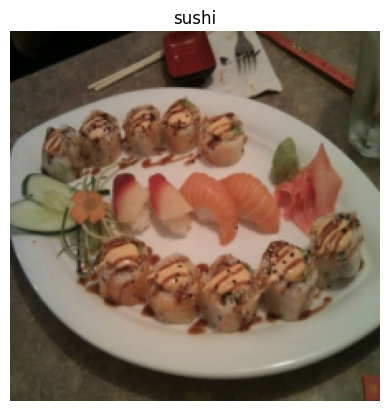

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

* **Input** - What goes into the model? (in the case, image tensors)
* **Output** - What comes out of the model/layer/block? (in the case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT Overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Table 1/3: different hyperparameters for the architecture/training.
* Four equations: math questions which define the functions of each layer/block

#### Figure 1

![Figure 1. ViT Model Overview](../assets/vit-figure-1-model-overview.png)

* Embedding: learnable representation (start with random numbers and improve over time)

#### ViT Overview: Inputs and Outputs

![ViT Overview: Inputs and Outputs](../assets/vit-overview-inputs-and-outputs.png)

#### Four equations

![Four equations](../assets/vit-four-equations.png)

#### Section 3.1 describes the various equations:

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_pathc_2_pos, ... image_patch_N_pos]
```

---

**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

---

**Equation 2&3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

---

**Equation 4:**

Similar to BERT's \texttt{[class]} token, we prepend a learnable embedding to the sequence of embedded patches ($\mathbf{z}_0^0 = \mathbf{x}_{\text{class}}$), whose state at the output of the Transformer encoder ($\mathbf{z}_L^0$) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

---

#### ViT Overview: Four Equations

![ViT Overview: Four Equations](../assets/vit-overview-four-equations.png)


#### Table 1

![Table 1. Details of ViT model variants](../assets/vit-table-1-details-of-ViT-model-variants.png)

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

>
> **Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
>

>
>**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
>

* Input image: $H\times{W}\times{C}$ (height x width x color channels)
* Output image: ${N \times (P^2 \cdot C)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, patch dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, patch dimension)


### 4.2 Turning a single image into patches

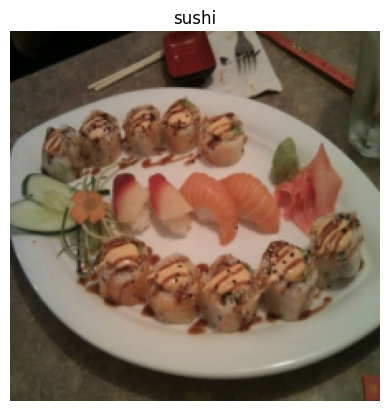

In [13]:
# View a single image
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

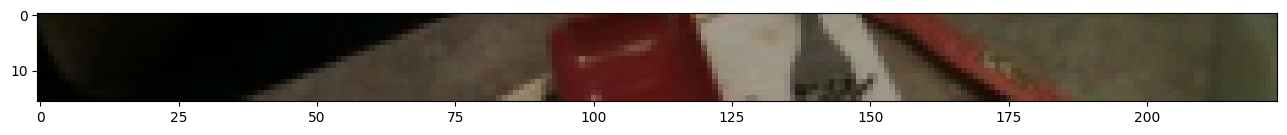

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # (C, H, W) -> (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


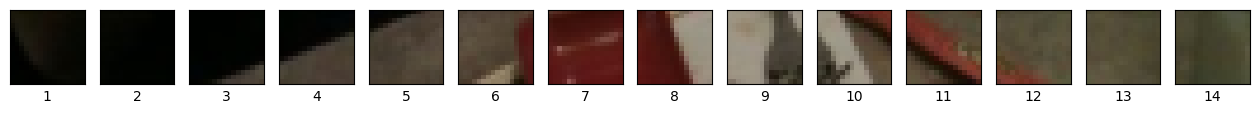

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches_per_row = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches_per_row}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through the number of patches per row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1) # set the patch label (1 -> 14)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [17]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches_per_row = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches_per_row}\
    \nNumber of patches per column: {num_patches_per_row}\
    \nTotal patches: {num_patches_per_row * num_patches_per_row}\
    \nPatch size: {patch_size} pixels x {patch_size} pixels")



print(image_permuted)
print(image_permuted.shape)

Number of patches per row: 14    
Number of patches per column: 14    
Total patches: 196    
Patch size: 16 pixels x 16 pixels
tensor([[[0.0980, 0.0902, 0.0431],
         [0.0941, 0.0863, 0.0353],
         [0.0863, 0.0784, 0.0196],
         ...,
         [0.3137, 0.3255, 0.2588],
         [0.3020, 0.3137, 0.2353],
         [0.2784, 0.2902, 0.2078]],

        [[0.0980, 0.0902, 0.0431],
         [0.1020, 0.0941, 0.0431],
         [0.1020, 0.0941, 0.0392],
         ...,
         [0.3255, 0.3373, 0.2667],
         [0.3255, 0.3373, 0.2549],
         [0.3098, 0.3255, 0.2353]],

        [[0.0941, 0.0824, 0.0431],
         [0.1098, 0.0980, 0.0549],
         [0.1059, 0.0980, 0.0510],
         ...,
         [0.3216, 0.3333, 0.2510],
         [0.3255, 0.3412, 0.2510],
         [0.3098, 0.3255, 0.2314]],

        ...,

        [[0.2706, 0.2627, 0.1922],
         [0.2706, 0.2588, 0.1922],
         [0.2510, 0.2431, 0.1725],
         ...,
         [0.4353, 0.2118, 0.1451],
         [0.4353, 0.2039, 

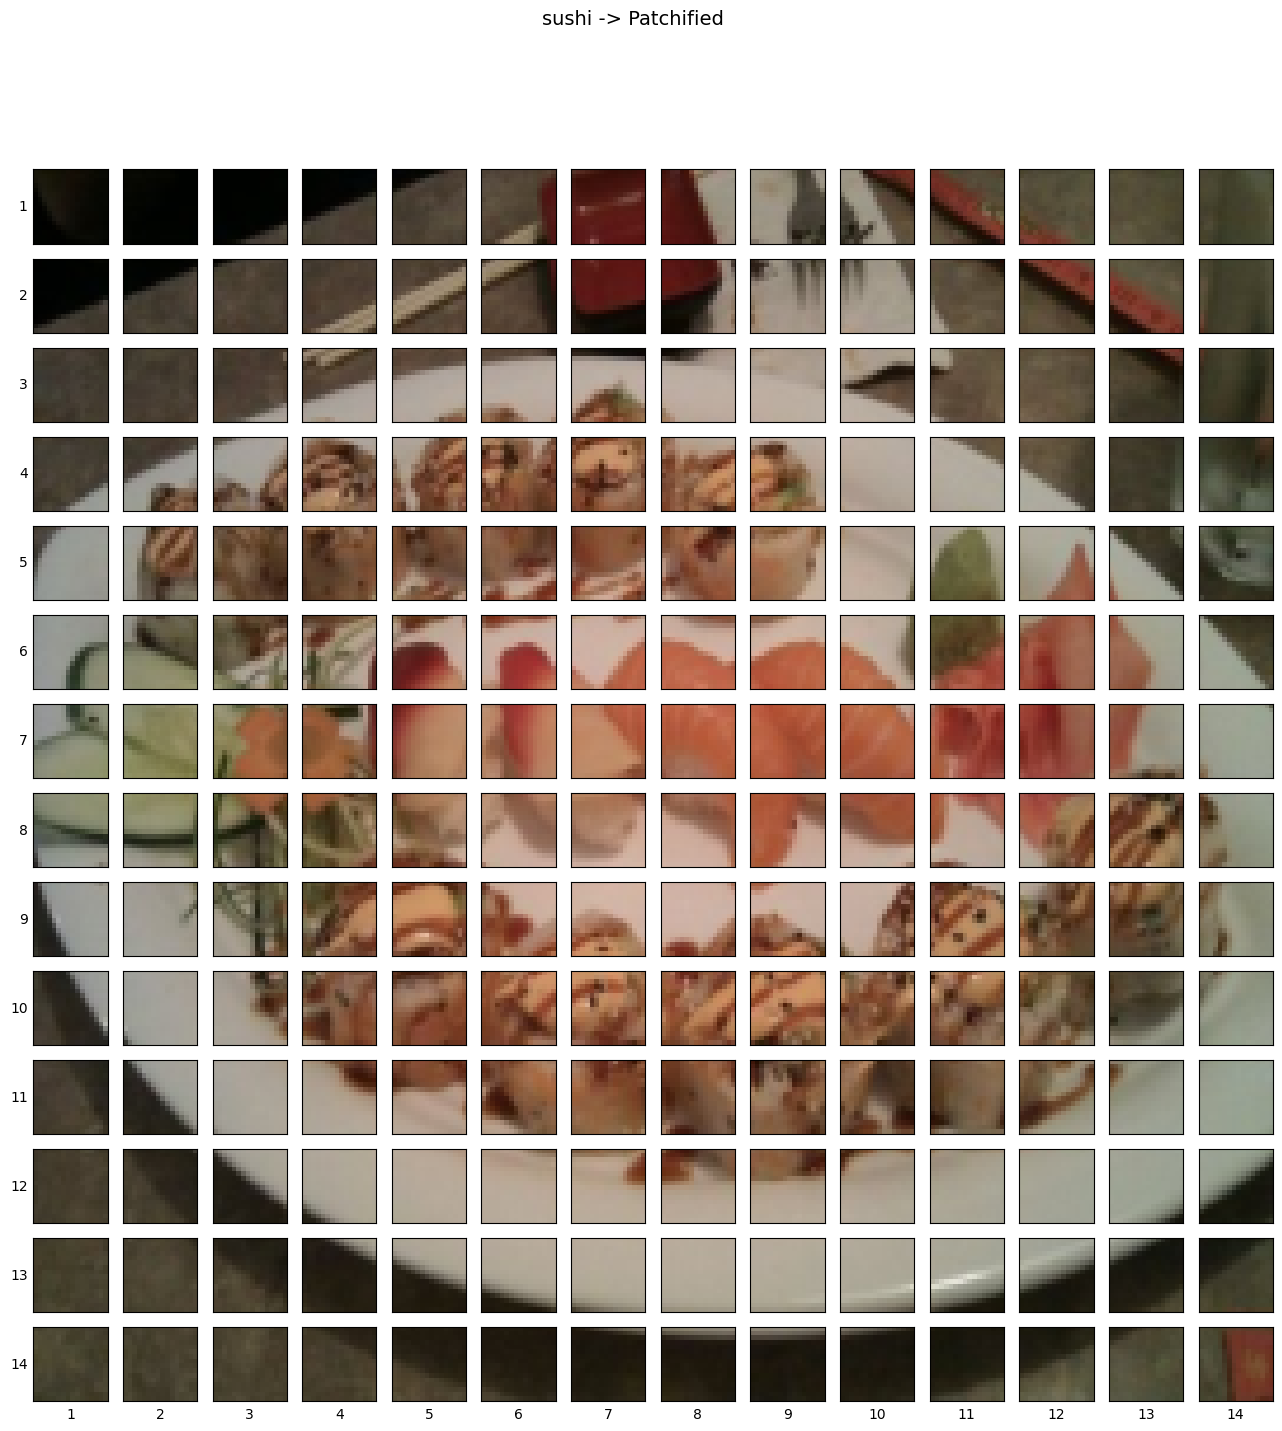

In [18]:
# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # one row for each patch
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information for each subplot
        axs[i, j].set_ylabel(i + 1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patche and turning them into patch embeddings

Create the image patches and image patch embedding in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`

In [19]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D = embedding dimension -> from Table 1
                   kernel_size=patch_size, # size of the patch 
                   stride=patch_size, # non-overlapping patches
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

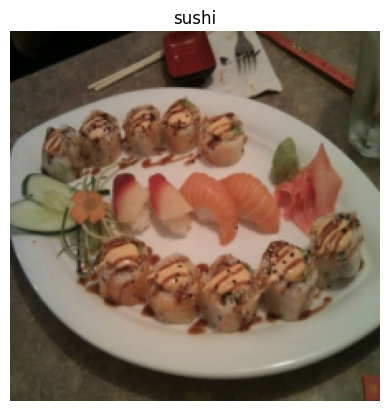

In [20]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [21]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)

In [22]:
#now we've passed a single image t the `conv2d` layer, it's shape is
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [312, 116, 608, 734, 478]


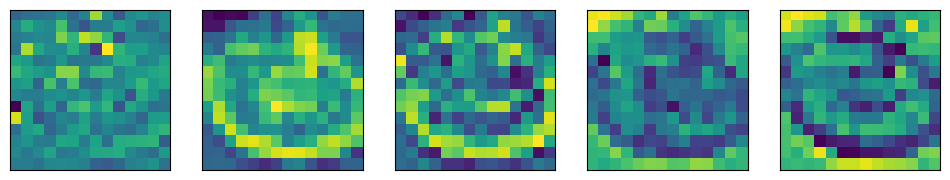

In [23]:
# plot random convolutional feature maps (embeddings)
import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexs}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [24]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0271, -0.0160, -0.0372, -0.0174, -0.1005, -0.0632, -0.0607,
           -0.2908, -0.1060,  0.0066, -0.0347, -0.1296, -0.1025, -0.1325],
          [-0.0005, -0.0025, -0.0929, -0.0850, -0.1121, -0.0145, -0.0390,
           -0.1667, -0.0773, -0.1471, -0.1209, -0.1956, -0.0783, -0.0956],
          [-0.0779, -0.0827, -0.1150, -0.0053,  0.0040, -0.1977, -0.2223,
           -0.2010, -0.1837, -0.3656, -0.1105, -0.1048, -0.0524, -0.0882],
          [-0.1212, -0.0634, -0.1209, -0.0770, -0.2324, -0.1697, -0.1488,
           -0.1000, -0.2631, -0.1996, -0.0827, -0.1269, -0.0999, -0.1414],
          [-0.1718, -0.2958, -0.1057, -0.1300, -0.2666, -0.0813,  0.0227,
           -0.0920, -0.2072, -0.1962, -0.1848, -0.1574, -0.2598, -0.0967],
          [-0.2674, -0.2740, -0.0941, -0.1001, -0.3186, -0.3904, -0.1794,
           -0.1354, -0.3693, -0.2600, -0.1301, -0.1827, -0.1973, -0.1621],
          [-0.1386, -0.1561, -0.1200, -0.1208, -0.1347, -0.2307, -0.1272,
           -0.1543, -0.2073, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [25]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [26]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).permute(0, 2, 1).shape

torch.Size([1, 196, 768])

Original image shape: torch.Size([3, 224, 224]) -> (color_channels, height, width)
Image feature map after conv2d layer: torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)
Image patch embeddings after flattening: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


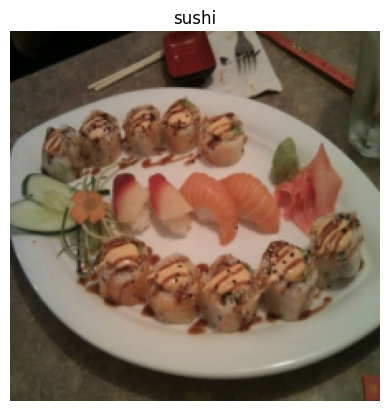

In [27]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape} -> (color_channels, height, width)")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(f"Image feature map after conv2d layer: {image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

# Flatten the feature maps into a sequence of patch embeddings
image_out_of_conv_flatten = flatten_layer(image_out_of_conv).permute(0, 2, 1) # (batch_size, number_of_patches, embedding_dim)
print(f"Image patch embeddings after flattening: {image_out_of_conv_flatten.shape} -> (batch_size, number_of_patches, embedding_dim)")

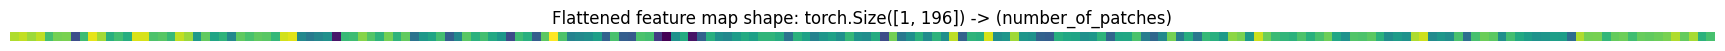

In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flatten[:, :, 0]
single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape} -> (number_of_patches)")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [29]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768): # From Table 1 for ViT-Base
        super().__init__()
        
        self.patch_size = patch_size
    
        # 3. Create a layer to turn an image into embedding patches using nn.Conv2
        self.patcher = nn.Conv2d(in_channels=in_channels, # 3
                                 out_channels=embedding_dim, # 768
                                 kernel_size=patch_size, # 16
                                 stride=patch_size, # 16
                                 padding=0)
        # 4. Create a layer to flatten the feature maps of the output of the layer in 3
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define a forward() that defines the forward computation steps
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1] # get the height/width of the image
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by the patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patch = self.patcher(x) # (batch_size, embedding_dim, feature_map_height, feature_map_width)
        x_flattened = self.flatten(x_patch).permute(0, 2, 1) # (batch_size, number_of_patches, embedding_dim)
        return x_flattened
    

In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through the patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape} -> (batch_size, number_of_patches, embedding_dim)")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


In [31]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250) # AssertionError: Input image size must be divisible by the patch size, image shape: 250, patch size: 16

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class to token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [32]:
patch_embedded_image

tensor([[[-0.0638,  0.0009, -0.0263,  ...,  0.0646, -0.0154,  0.0129],
         [-0.0217, -0.0134, -0.0353,  ...,  0.0157, -0.0111,  0.0103],
         [-0.1090,  0.0181, -0.0635,  ...,  0.0480, -0.0085,  0.0137],
         ...,
         [-0.2367,  0.0488, -0.1895,  ...,  0.2150, -0.0625,  0.1033],
         [-0.3423,  0.0921, -0.1351,  ...,  0.2180, -0.1212,  0.1242],
         [-0.3107, -0.0127, -0.0578,  ...,  0.2267, -0.1928,  0.0539]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-6.3817e-02,  8.7570e-04, -2.6301e-02,  ...,  6.4645e-02,
          -1.5420e-02,  1.2917e-02],
         [-2.1709e-02, -1.3443e-02, -3.5279e-02,  ...,  1.5700e-02,
          -1.1063e-02,  1.0340e-02],
         ...,
         [-2.3671e-01,  4.8799e-02, -1.8949e-01,  ...,  2.1502e-01,
          -6.2454e-02,  1.0328e-01],
         [-3.4234e-01,  9.2112e-02, -1.3511e-01,  ...,  2.1796e-01,
          -1.2118e-01,  1.2419e-01],
         [-3.1073e-01, -1.2675e-02, -5.7784e-02,  ...,  2.2668e-01,
          -1.9276e-01,  5.3918e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-6.3817e-02,  8.7570e-04, -2.6301e-02,  ...,  6.4645e-02,
           -1.5420e-02,  1.2917e-02],
          [-2.1709e-02, -1.3443e-02, -3.5279e-02,  ...,  1.5700e-02,
           -1.1063e-02,  1.0340e-02],
          ...,
          [-2.3671e-01,  4.8799e-02, -1.8949e-01,  ...,  2.1502e-01,
           -6.2454e-02,  1.0328e-01],
          [-3.4234e-01,  9.2112e-02, -1.3511e-01,  ...,  2.1796e-01,
           -1.2118e-01,  1.2419e-01],
          [-3.1073e-01, -1.2675e-02, -5.7784e-02,  ...,  2.2668e-01,
           -1.9276e-01,  5.3918e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]
print(f"Number of patches: {number_of_patches}, Embedding dimension: {embedding_dim}")

# Create the learnable 1D position embeddings
position_embeddings = nn.Parameter(torch.ones(1,
                                              number_of_patches + 1, # +1 for class token
                                              embedding_dim))
position_embeddings, position_embeddings.shape

Number of patches: 196, Embedding dimension: 768


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-6.3817e-02,  8.7570e-04, -2.6301e-02,  ...,  6.4645e-02,
           -1.5420e-02,  1.2917e-02],
          [-2.1709e-02, -1.3443e-02, -3.5279e-02,  ...,  1.5700e-02,
           -1.1063e-02,  1.0340e-02],
          ...,
          [-2.3671e-01,  4.8799e-02, -1.8949e-01,  ...,  2.1502e-01,
           -6.2454e-02,  1.0328e-01],
          [-3.4234e-01,  9.2112e-02, -1.3511e-01,  ...,  2.1796e-01,
           -1.2118e-01,  1.2419e-01],
          [-3.1073e-01, -1.2675e-02, -5.7784e-02,  ...,  2.2668e-01,
           -1.9276e-01,  5.3918e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embeddings
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9362, 1.0009, 0.9737,  ..., 1.0646, 0.9846, 1.0129],
         [0.9783, 0.9866, 0.9647,  ..., 1.0157, 0.9889, 1.0103],
         ...,
         [0.7633, 1.0488, 0.8105,  ..., 1.2150, 0.9375, 1.1033],
         [0.6577, 1.0921, 0.8649,  ..., 1.2180, 0.8788, 1.1242],
         [0.6893, 0.9873, 0.9422,  ..., 1.2267, 0.8072, 1.0539]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings

Now let's do it all in one cell

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapé of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape} -> (batch_size, number_of_patches, embedding_dim)")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
print(f"Class token shape: {class_token.shape} -> (batch_size, 1, embedding_dim)")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                              number_of_patches + 1, # +1 for class token
                                              embedding_dim), requires_grad=True)

# 9. Add the position embedding to the patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)
Class token shape: torch.Size([1, 1, 768]) -> (batch_size, 1, embedding_dim)
Patch embedding with class token shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)
Patch and position embedding shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


## 5. Equation 2: Multihead Self-Attention (MSA Block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?

> * In the case, we have a series of embedded image patches, which patch significantly relates to another patch.
> We want the neural network (ViT) to learn this relationship/representation
* To replicate MSA in PyTorch we can use: https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
* Layer Norm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy
> * Normalization = make everything have the same mean and same standard deviation
> * In PyTorch = https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in the case, the $D$ dimension is the embedding dimension.
>   * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size

In [42]:
class MutliHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    def __init__(self,
                 embedding_dimension: int = 768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 num_heads: int = 12, # Heads from Table 1 for ViT-Base
                 attn_dropout: int = 0):
        super().__init__()
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        # Create a multihead attention layer (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # batch_first=True -> (batch_size, sequence_length, feature) -> (batch_size, number_of_patches, embedding_dimension)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. Pass the input through the norm layer
        x_norm = self.layer_norm(x)
        # 2. Pass the normalized input through the multi-head attention layer
        attn_output, _ = self.multihead_attn(query=x_norm,
                                             key=x_norm,
                                             value=x_norm,
                                             need_weights=False) # we don't need the attention weights for ViT
        return attn_output

In [43]:
# Create an instance MSA block
multihead_self_attention_block = MutliHeadSelfAttentionBlock(
    embedding_dimension=768, num_heads=12, attn_dropout=0
)

# Pass the patch and position embedding sequence through the MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")

Input shape of MSA block: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)
Output shape of MSA block: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


In [44]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9362, 1.0009, 0.9737,  ..., 1.0646, 0.9846, 1.0129],
         [0.9783, 0.9866, 0.9647,  ..., 1.0157, 0.9889, 1.0103],
         ...,
         [0.7633, 1.0488, 0.8105,  ..., 1.2150, 0.9375, 1.1033],
         [0.6577, 1.0921, 0.8649,  ..., 1.2180, 0.8788, 1.1242],
         [0.6893, 0.9873, 0.9422,  ..., 1.2267, 0.8072, 1.0539]]],
       grad_fn=<AddBackward0>)

In [45]:
patched_image_through_msa_block

tensor([[[-0.2140, -0.2079,  0.0679,  ..., -0.4321,  0.8910, -0.4682],
         [-0.2143, -0.2103,  0.0640,  ..., -0.4340,  0.8989, -0.4742],
         [-0.2196, -0.2121,  0.0646,  ..., -0.4317,  0.8918, -0.4712],
         ...,
         [-0.2111, -0.1932,  0.0760,  ..., -0.4256,  0.9067, -0.4818],
         [-0.2059, -0.1937,  0.0730,  ..., -0.4305,  0.9054, -0.4834],
         [-0.2070, -0.1972,  0.0693,  ..., -0.4286,  0.9042, -0.4808]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilaye Perceptron (MLP Block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
> * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
> * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
> * GELU in PyTorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
* **Dropout** = Dropiout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

### 6.1 The MLP layer(s)

The term [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

> The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note**: A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

In [46]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int = 768,
                 mlp_size: int = 3072, # From Table 1 for ViT-Base
                 mlp_dropout: float = 0.1):
        super().__init__()
        
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        # Create the MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dimension, 
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dimension),
            nn.Dropout(mlp_dropout)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x)) # Same as above

In [47]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dimension=768,
                     mlp_size=3072,
                     mlp_dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP Block: {patched_image_through_msa_block.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")
print(f"Output shape of MLP Block: {patched_image_through_mlp_block.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")

Input shape of MLP Block: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)
Output shape of MLP Block: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


In [48]:
patched_image_through_msa_block

tensor([[[-0.2140, -0.2079,  0.0679,  ..., -0.4321,  0.8910, -0.4682],
         [-0.2143, -0.2103,  0.0640,  ..., -0.4340,  0.8989, -0.4742],
         [-0.2196, -0.2121,  0.0646,  ..., -0.4317,  0.8918, -0.4712],
         ...,
         [-0.2111, -0.1932,  0.0760,  ..., -0.4256,  0.9067, -0.4818],
         [-0.2059, -0.1937,  0.0730,  ..., -0.4305,  0.9054, -0.4834],
         [-0.2070, -0.1972,  0.0693,  ..., -0.4286,  0.9042, -0.4808]]],
       grad_fn=<TransposeBackward0>)

In [49]:
patched_image_through_mlp_block

tensor([[[-0.0898, -0.0203,  0.2737,  ..., -0.0321, -0.1054,  0.3213],
         [-0.0454,  0.0114,  0.2393,  ..., -0.0000, -0.1459,  0.2779],
         [-0.0794, -0.0788,  0.2012,  ..., -0.0641, -0.1979,  0.3540],
         ...,
         [-0.0608, -0.0946,  0.2044,  ...,  0.0548, -0.1768,  0.1596],
         [-0.1067, -0.0000,  0.1850,  ...,  0.1290, -0.1914,  0.2455],
         [-0.1318, -0.0177,  0.1309,  ...,  0.0871, -0.0424,  0.2770]]],
       grad_fn=<MulBackward0>)

## 7. Create the Transformer Encoder

Time to stack together our `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an ["encoder" or "auto encoder"](https://paperswithcode.com/method/autoencoder) generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block, and residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output.

Where the subsequence output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

```python
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

What does this do?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note**: The iconic computer vision architecture "ResNet" is named so because of the introduction of residual connections. You can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html).

### 7.1 Creating a Transformer Encoder by combining our custom made layers

In [64]:
class TransformerEncorderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768, # Hidden size D from table 1, 768 for ViT-Base
                 num_heads:int = 12, # Heads from table 1, 12 for ViT-Base
                 mlp_size:int = 3072, # MLP size from table 1, 3072 for ViT-Base
                 mlp_dropout:float = 0.1,
                 attn_dropout:float = 0.0):
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MutliHeadSelfAttentionBlock(embedding_dimension=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # Create MLP Block (equation 3)
        self.mlp_block = MLPBlock(embedding_dimension=embedding_dim,
                                  mlp_size=mlp_size,
                                  mlp_dropout=mlp_dropout)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x # Residual connection for MSA block / Skip connection (That's where ResNet comes from)
        x = self.mlp_block(x) + x # Residual connection for MLP block
        return x

In [65]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncorderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches + 1, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncorderBlock (TransformerEncorderBlock)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MutliHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)              --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create an Transformer Encoder layer with inbuilt PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html

We can create an Transformer Encoder with pure PyTorch layers: https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

In [66]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,  # embedding dimension
    nhead=12,  # number of heads
    dim_feedforward=3072,  # MLP size
    dropout=0.1,
    activation="gelu",
    batch_first=True, # (batch_size, sequence_length, feature) -> (batch_size, number_of_patches, embedding_dimension
    norm_first=True, # We want to do layer norm first
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## 8. Putting it all together to create ViT

In [70]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(
        self,
        img_size: int = 224,  # Table 3 from the ViT paper
        in_channels: int = 3,
        patch_size: int = 16,
        num_transformer_layers: int = 12,  # Table 1 for "Layers" for ViT-base
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: int = 0,
        mlp_dropout: int = 0.1,
        embedding_dropout: int = 0.1,  # Dropout for patch and position embeddings
        num_classes: int = 1000,  # number of classes in the classification problem
    ):
        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert (
            img_size % patch_size == 0
        ), f"Image size must be divisible by the patch size, image size: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (height * width / patch^2)
        self.num_patches = int(img_size * img_size // patch_size**2)

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim), requires_grad=True
        )
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
        
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create the Transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncorderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
        
        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)
        
        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)
        
        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
        x = self.embedding_dropout(x)
        
        # Pass position and patch emdedding to Transform Encoder
        x = self.transformer_encoder(x)
        
        # Put 0th index logit through the classifier (equation 2 & 3)
        x = self.classifier(x[:, 0])
        
        return x

In [71]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
print(class_embedding.shape)
print(class_embedding.expand(batch_size, -1, -1).shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [75]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizz, steak, and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to the ViT instance
vit(random_image_tensor)


tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of the ViT model

In [76]:
from torchinfo import summary

summary(
    model=ViT(num_classes=len(class_names)),
    input_size=(1, 3, 224, 224),  # (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncorderBlock (0)                          [1, 197, 768]        [1, 197, 768] 

## 9.1 Setting up training code fo the cutom ViT

We've replicated the ViT architecture, now let's see how it performs on the FoodVision Mini data.

### 9.1 Create an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [79]:
optimizer = torch.optim.Adam(
    vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1
)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used. So since it's a multi-class classifiction we'll use the `torch.nn.CrossEntropyLoss()`.

In [80]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training the ViT model

In [83]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(
    vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1
)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=5,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

 20%|██        | 1/5 [11:26<45:47, 686.78s/it]

Epoch: 1 | train_loss: 2.0831 | train_acc: 0.4062 | test_loss: 3.0274 | test_acc: 0.2604


 40%|████      | 2/5 [20:39<30:23, 607.71s/it]

Epoch: 2 | train_loss: 1.5228 | train_acc: 0.3750 | test_loss: 2.2371 | test_acc: 0.2604


 60%|██████    | 3/5 [31:24<20:49, 624.90s/it]

Epoch: 3 | train_loss: 1.2847 | train_acc: 0.4062 | test_loss: 2.0652 | test_acc: 0.2604


 80%|████████  | 4/5 [40:26<09:52, 592.05s/it]

Epoch: 4 | train_loss: 1.4715 | train_acc: 0.2812 | test_loss: 1.5442 | test_acc: 0.1979


100%|██████████| 5/5 [48:45<00:00, 585.03s/it]

Epoch: 5 | train_loss: 1.2686 | train_acc: 0.2852 | test_loss: 1.2454 | test_acc: 0.1979


### 9.4 What the training setup is missing

How is the training setup different to the ViT paper?

We've replicated the model architecture correctly. But what was different between the training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things the training implementation is missing:
Prevent underfitting:
* Data - the setup uses far less data (225 vs millions)

Prevent overfitting:
* [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) - Start with a low learning rate and increase to a base LR
* [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) - As the model gets closer to convergence, start to lower the learning rate
* [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) - prevent gradients from getting to big

Search "pytorch [technique name]"

### 9.5 Plotting loss curves for the model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

'cuda'

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?
* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [84]:
# Cost of a TPUv3 for 30 days
cost = 8 * 24 * 30
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost}USD")

Cost of renting a TPUv3 for 30 straight days: $5760USD


In [85]:
# The following requires torchvision v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.1+cu126
0.24.1+cu126


In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [87]:
# Get pretrained weights for ViT-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\AOL81HC/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:34<00:00, 9.99MB/s] 


In [88]:
from torchinfo import summary

summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),  # (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [89]:
# Get automic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [90]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model

### 10.4 Train feature extractor ViT model

In [91]:
from going_modular.going_modular import engine
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)``

 10%|█         | 1/10 [03:43<33:35, 223.96s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 20%|██        | 2/10 [07:40<30:50, 231.37s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 30%|███       | 3/10 [11:49<27:54, 239.21s/it]

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 40%|████      | 4/10 [15:10<22:25, 224.28s/it]

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


 50%|█████     | 5/10 [19:02<18:56, 227.21s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [23:07<15:32, 233.11s/it]

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280


 70%|███████   | 7/10 [26:53<11:31, 230.66s/it]

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883


 80%|████████  | 8/10 [30:45<07:42, 231.32s/it]

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081


 90%|█████████ | 9/10 [34:40<03:52, 232.45s/it]

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384


100%|██████████| 10/10 [39:18<00:00, 235.80s/it]

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of the pretrained ViT feature extractor model

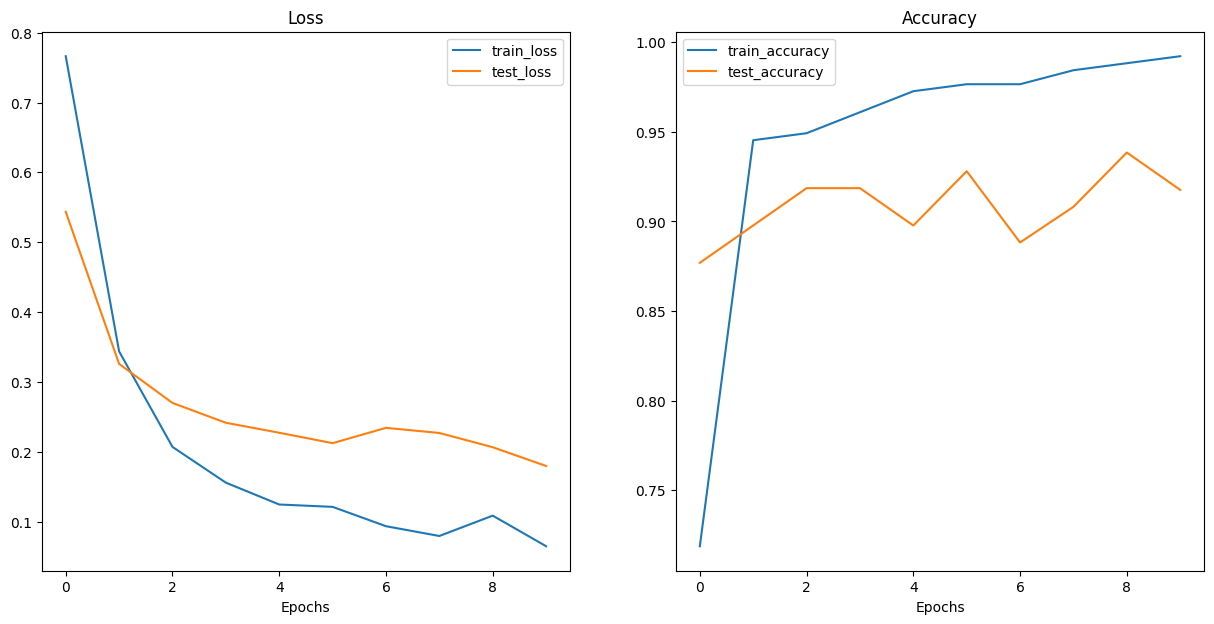

In [92]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save the best performing ViT model

We want to check the filesize because if we wanted to deploy a model to a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions

In [93]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [94]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on a custom image

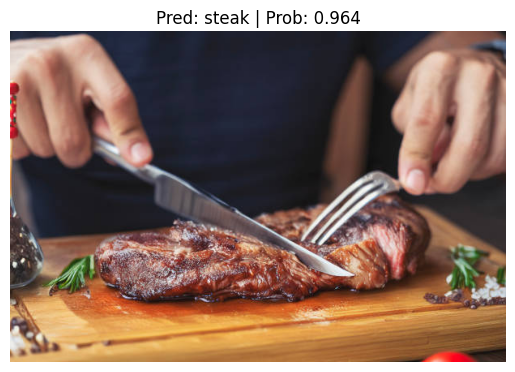

In [95]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "data/steak-pic.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)